In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from collections import Counter

In [2]:
df = pd.read_csv('appen/output_batch_correct_v2/feedback/product_attribution_020323_030323_valid_units_aggregated_030623.csv')

In [3]:
df_attributes = pd.read_csv('../attribute_extraction_metadata_template/attribute_definition_top25L2_filtered_augmented_redacted_addedsinglemulti_01182023.csv')

In [4]:
df_attributes_orig = pd.read_csv('../attribute_extraction_metadata_template/Initial Attribute Definition for First Release - UPDATED SHEET .csv')

In [5]:
cats = set(df_attributes['category'])

In [6]:
df_attributes_orig_sub = df_attributes_orig[
    (df_attributes_orig.category.apply(lambda x: x in cats)) & (df_attributes_orig['entry mode'].apply(lambda x: x != 'free_text'))
]

In [7]:
df_attributes_orig_sub_group = df_attributes_orig_sub[['attribute_field', 'category_attributevalue']].groupby('attribute_field').agg({
    'category_attributevalue': lambda x: sorted(set(reduce(lambda x, y: x+y, [[str(j) for j in eval(i)] for i in x])))
}).reset_index()

In [8]:
df_attributes_orig_sub_group

,attribute_field,category_attributevalue
0,Adjustable Fit,"[Chest Adjustment, Hip Adjustment, Shoulder Ad..."
1,Adjustable Length,"[No, Yes]"
2,Age Range Description,"[Adult, All Ages, Infant, Kids, Teen, Toddler]"
3,Alarm Type,"[Beep Alarm, Bell Alarm, Gradual Alarm, Loud A..."
4,Alert Type,"[Audio Only, Audio and Motion, Motion Only]"
...,...,...
188,Wall Light Type,"[Candelabra, Reading, Swing Arm, Wall Lamp, Wa..."
189,Watch Movement Type,"[Analog Quartz, Automatic, Automatic Self Wind..."
190,Water Resistance Level,"[Not Water-Resistant, Water-Resistant, Waterpr..."
191,Weave Type,"[Basket, Braided, Dobby, Double Cloth, Flat Wo..."


In [9]:
df_attributes_group = df_attributes.groupby('attribute_field').agg({
    'category_attributevalue': lambda x: sorted(set(reduce(lambda x, y: x+y, [[str(j) for j in eval(i)] for i in x])))
}).reset_index()

In [10]:
df_attributes_group

,attribute_field,category_attributevalue
0,Absorption,"[High, Low, Medium, No Absorption, None]"
1,Additional Accessories,"[Coaster, Lid, None, Saucer, Spoon, Straw]"
2,Adjustable Fit,"[Chest Adjustment, Hip Adjustment, Shoulder Ad..."
3,Adjustable Length,"[No, Yes]"
4,Age Range Description,"[Adult, All Ages, Infant, Kids, Teen, Toddler]"
...,...,...
225,Wall Light Type,"[Candelabra, Reading, Swing Arm, Wall Lamp, Wa..."
226,Watch Movement Type,"[Analog Quartz, Automatic, Automatic Self Wind..."
227,Water Resistance Level,"[Not Water-Resistant, Water-Resistant, Waterpr..."
228,Weave Type,"[Basket, Braided, Dobby, Double Cloth, Flat Wo..."


In [11]:
attr_vals_normalized = {}
for i in df_attributes_group.to_dict('records'):
    attr_vals_normalized[i['attribute_field']] = set(i['category_attributevalue'])

attr_vals_orig_normalized = {}
for i in df_attributes_orig_sub_group.to_dict('records'):
    attr_vals_orig_normalized[i['attribute_field']] = set(i['category_attributevalue'])

In [12]:
all_kvpairs = set()
all_orig_kvpairs = set()

for k in attr_vals_normalized:
    for v in attr_vals_normalized[k]:
        all_kvpairs.add((k, v))

for k in attr_vals_orig_normalized:
    for v in attr_vals_orig_normalized[k]:
        all_orig_kvpairs.add((k, v))

In [13]:
len(attr_vals_normalized), len(attr_vals_orig_normalized)

(230, 193)

In [14]:
len(all_kvpairs), len(all_orig_kvpairs)

(13592, 6875)

In [19]:
recs = []
for i in df.to_dict('records'):
    res_normalized = []
    res_custom = []
    res = [] if ((not isinstance(i['rater_output_processed'], str)) and (np.isnan(i['rater_output_processed']))) else i['rater_output_processed'].split('\n')
    for j in res:
        k, v = j.split(' > ')[-2:]
        assert k in attr_vals_normalized
        if k in attr_vals_orig_normalized and v in attr_vals_orig_normalized[k]:
            res_normalized.append((k, v))
        else:
            res_custom.append((k, v))
    i['attr_name_value_pairs_normalized'] = sorted(set(res_normalized))
    i['attr_name_value_pairs_custom'] = sorted(set(res_custom))
    recs.append(i)
df = pd.DataFrame(recs)

In [20]:
df['attr_name_value_pairs_normalized'].apply(len).mean(), df['attr_name_value_pairs_custom'].apply(len).mean()

(4.618071389260162, 0.9330136016982468)

<AxesSubplot: ylabel='Frequency'>

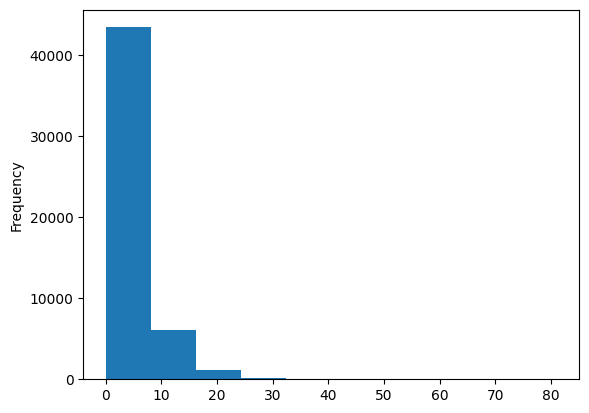

In [21]:
df['attr_name_value_pairs_normalized'].apply(len).plot.hist()

<AxesSubplot: ylabel='Frequency'>

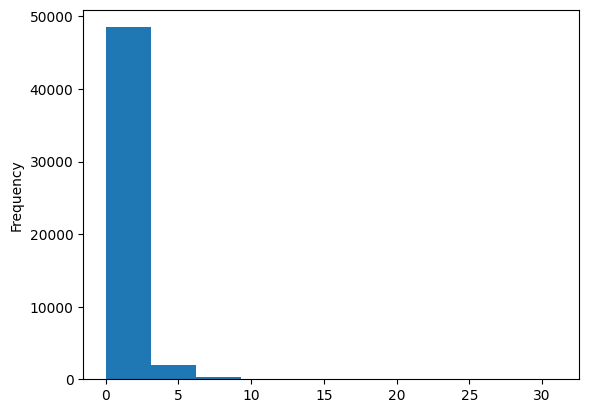

In [22]:
df['attr_name_value_pairs_custom'].apply(len).plot.hist()

In [23]:
normalized_attributes = reduce(lambda x,y: x+y, df['attr_name_value_pairs_normalized'].apply(lambda x: [i[0] for i in x]))
custom_attributes = reduce(lambda x,y: x+y, df['attr_name_value_pairs_custom'].apply(lambda x: [i[0] for i in x]))

In [24]:
normalized_kvpairs = reduce(lambda x,y: x+y, df['attr_name_value_pairs_normalized'])
custom_kvpairs = reduce(lambda x,y: x+y, df['attr_name_value_pairs_custom'])

In [25]:
len(set(normalized_attributes)), len(set(custom_attributes))

(158, 106)

In [26]:
len(set(normalized_kvpairs)), len(set(custom_kvpairs))

(2655, 31228)

In [27]:
Counter(normalized_attributes).most_common(5)

[('Primary Color', 56936),
 ('Materials', 46904),
 ('Size', 34841),
 ('Department', 19908),
 ('Occasion & Lifestyle', 13188)]

In [28]:
Counter(custom_attributes).most_common(5)

[('Alpha Size', 23253),
 ('Size', 8474),
 ('Materials', 2395),
 ('Item Types', 2076),
 ('Primary Color', 1647)]

In [29]:
Counter(normalized_kvpairs).most_common(5)

[(('Primary Color', 'Black'), 10619),
 (('Department', 'Women'), 9475),
 (('Primary Color', 'White'), 6715),
 (('Department', 'Men'), 5649),
 (('Materials', 'Polyester'), 5426)]

In [30]:
Counter(custom_kvpairs).most_common(5)

[(('Number of Items', '1'), 572),
 (('Use', 'Indoor'), 215),
 (('Use', 'For Pillow Cases'), 199),
 (('Brand', 'Apple'), 174),
 (('Use', 'Smoking'), 157)]

In [31]:
len(set(normalized_attributes)) / len(attr_vals_orig_normalized) # normalized original no free-text

0.8186528497409327

In [32]:
len(set(custom_attributes).union(set(normalized_attributes))) / len(attr_vals_normalized) # add in augmented free-text attributes

0.8

In [33]:
len(set(normalized_kvpairs).intersection(all_orig_kvpairs)) / len(all_orig_kvpairs) # normalized original no free-text

0.3861818181818182

In [34]:
len((set(normalized_kvpairs).union(custom_kvpairs)).intersection(all_kvpairs)) / len(all_kvpairs) # add in augmented free-text attributes

0.24955856386109476

In [35]:
any(['|' in i[0] for i in all_kvpairs]), any(['|' in i[1] for i in all_kvpairs]), any(['\n' in i[0] for i in all_kvpairs]), any(['\n' in i[1] for i in all_kvpairs])

(False, False, False, False)

In [36]:
df['attr_name_value_pairs_normalized_text'] = df['attr_name_value_pairs_normalized'].apply(lambda x: '\n'.join([i[0] + '|' + i[1] for i in x]))

In [37]:
df.head(2)

,Label_Ordering,Sample_Method,Product_Id,Title,Product_Description,Main_Image_Url,Product_Category,L2_Category,Rater1_Answer,Rater2_Answer,Final Answer,final_output,rater_output_processed,attr_name_value_pairs_normalized,attr_name_value_pairs_custom,attr_name_value_pairs_normalized_text
0,0,only_text,611bbb365b0bd8698b670d9d,"Rattan Basket Pet Dome and Animal Bed, with Me...",Features\n- Rattan wicker brings a classic sty...,NaN,Home & Garden > Pet Products > Cat Supplies > ...,Home & Garden > Pet Products,NaN,Home & Garden > Pet Products > Cat Supplies > ...,Home & Garden > Pet Products > Cat Supplies > ...,\nHome & Garden > Pet Products > Cat Supplies ...,Home & Garden > Pet Products > Cat Supplies > ...,"[(Materials, Cotton), (Materials, Metal), (Mat...","[(Materials, Water Hyacinth)]",Materials|Cotton\nMaterials|Metal\nMaterials|P...
1,1,only_text,61a9c0160dcaf9e1da138df1,10Pcs 7Pcs 2Pcs 1Pcs Tempered Glass For Iphone...,welcome to my store!\r\n\r\nFeatures:\r\nCompa...,NaN,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,"[(Hardness (Moh's Scale), 9h), (Item Condition...",[],Hardness (Moh's Scale)|9h\nItem Condition|New\...


In [40]:
df_out = df[['Label_Ordering', 'Sample_Method', 'Product_Id', 'Product_Category', 'Title', 'Product_Description', 
             'Main_Image_Url', 'rater_output_processed', 'attr_name_value_pairs_normalized', 
             'attr_name_value_pairs_custom', 'attr_name_value_pairs_normalized_text']].rename(columns={
        'Label_Ordering': 'label_ordering',
        'Sample_Method': 'sample_method',
        'Product_Id': 'pid',
        'Product_Category': 'category',
        'Title': 'title',
        'Product_Description': 'description',
        'Main_Image_Url': 'main_img_url',
    })

In [41]:
df_out

,label_ordering,sample_method,pid,category,title,description,main_img_url,rater_output_processed,attr_name_value_pairs_normalized,attr_name_value_pairs_custom,attr_name_value_pairs_normalized_text
0,0,only_text,611bbb365b0bd8698b670d9d,Home & Garden > Pet Products > Cat Supplies > ...,"Rattan Basket Pet Dome and Animal Bed, with Me...",Features\n- Rattan wicker brings a classic sty...,NaN,Home & Garden > Pet Products > Cat Supplies > ...,"[(Materials, Cotton), (Materials, Metal), (Mat...","[(Materials, Water Hyacinth)]",Materials|Cotton\nMaterials|Metal\nMaterials|P...
1,1,only_text,61a9c0160dcaf9e1da138df1,Cellphones & Telecommunications > Mobile Phone...,10Pcs 7Pcs 2Pcs 1Pcs Tempered Glass For Iphone...,welcome to my store!\r\n\r\nFeatures:\r\nCompa...,NaN,Cellphones & Telecommunications > Mobile Phone...,"[(Hardness (Moh's Scale), 9h), (Item Condition...",[],Hardness (Moh's Scale)|9h\nItem Condition|New\...
2,2,only_text,619e5cbac10add65da6fe6cb,"Home & Garden > Arts, Crafts & Sewing > Needle...",Frog and Book DIY 5D Diamond Painting Full Dri...,Package Include:\n1 X Diamond Cloth (diamonds ...,NaN,"Home & Garden > Arts, Crafts & Sewing > Needle...","[(Materials, Canvas), (Surface Recommendation,...","[(Use, DIY Crafts)]",Materials|Canvas\nSurface Recommendation|Ceiling
3,3,only_text,60ed02663dd63e676ce0b4fa,Shoes > Women's Shoes > Women's Sandals,Rhinestone Sandals Women's Diamond Thick Heel ...,"Welcome to buy our products, wish you a happy ...",NaN,Shoes > Men's Shoes > Men's Sandals > Departme...,"[(Department, Women)]",[],Department|Women
4,4,text_and_img,6182639876b66f2c68b39992,Home Improvement > Lights & Lighting > LED Lig...,"20M/65.6FT Bluetooth LED Strip Lights, RGB Col...","Description:\r\n1.5050wifi light strip, take y...",https://canary.contestimg.wish.com/api/webimag...,Home Improvement > Lights & Lighting > LED Lig...,"[(Connectivity, Homeplug), (Item Features, Col...","[(Alpha Size, 17 17 6), (Alpha Size, > 17 17...",Connectivity|Homeplug\nItem Features|Color Cha...
...,...,...,...,...,...,...,...,...,...,...,...
50871,51291,text_and_img,60b522c6da9c474d279622a8,Home & Garden > Garden Supplies > Seed Dissemi...,Garden Tech 5040415 1.25 lbs Sulfur Dust,<p>We provide a wide range of products to sati...,https://canary.contestimg.wish.com/api/webimag...,Home & Garden > Garden Supplies > Seed Dissemi...,"[(Pest Type, Insect Control), (Primary Color, ...",[],Pest Type|Insect Control\nPrimary Color|Red
50872,51292,only_text,5ff80b2824f716c3010150d4,Jewelry & Accessories > Rings,Adorable Rabbit Mouse Ring 925 Sterling Silver...,(a).Item: open ring \n(b). Packing: 1pc\n(C). ...,NaN,Jewelry & Accessories > Rings > Occasion & Lif...,"[(Main Stone, Zircon), (Materials, Silver), (M...",[],Main Stone|Zircon\nMaterials|Silver\nMaterials...
50873,51293,text_and_img,60ab86e8ab4212dc38a328a6,"Home & Garden > Arts, Crafts & Sewing > Appare...",To-m Hollan-d Umbr 44mm 1.75inch Brooch Backpa...,pins broach 44mm 1.75inch Snap-in Craft 3 Inch...,https://canary.contestimg.wish.com/api/webimag...,"Home & Garden > Arts, Crafts & Sewing > Appare...","[(Primary Color, White)]",[],Primary Color|White
50874,51294,only_text,5ff5a7c2eafa610b9ca30e3a,Jewelry & Accessories > Rings,14k Gold Simulated Ruby White CZ Cross Filigre...,14k Gold Simulated Ruby White CZ Cross Filigre...,NaN,Jewelry & Accessories > Rings > Main Stone > R...,"[(Department, Women), (Main Stone, Ruby), (Mat...",[],Department|Women\nMain Stone|Ruby\nMaterials|G...


In [42]:
len(set(df_out['pid'])), len(df_out)

(50876, 50876)

In [43]:
len(set(df_out['title'] + df_out['description'])), len(df_out)

(50873, 50876)

In [44]:
df_out_text = df_out[df_out.sample_method == 'only_text']
df_out_hybrid = df_out[df_out.sample_method == 'text_and_img']

In [45]:
len(df_out_text), len(df_out_hybrid)

(32374, 18502)

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
train_text, _ = train_test_split(df_out_text, test_size=.4, random_state=42)
val_text, test_text = train_test_split(_, test_size=0.5, random_state=42)

train_hybrid, _ = train_test_split(df_out_hybrid, test_size=.4, random_state=42)
val_hybrid, test_hybrid = train_test_split(_, test_size=0.5, random_state=42)

In [48]:
len(train_text), len(val_text), len(test_text)

(19424, 6475, 6475)

In [49]:
len(train_hybrid), len(val_hybrid), len(test_hybrid)

(11101, 3700, 3701)

In [50]:
!ls processed

appen_020323_delivered_022123_validated_product_attr_textandimg_test.json
appen_020323_delivered_022123_validated_product_attr_textandimg_test.json.dvc
appen_020323_delivered_022123_validated_product_attr_textandimg_train.json
appen_020323_delivered_022123_validated_product_attr_textandimg_train.json.dvc
appen_020323_delivered_022123_validated_product_attr_textandimg_val.json
appen_020323_delivered_022123_validated_product_attr_textandimg_val.json.dvc
appen_020323_delivered_022123_validated_product_attr_textonly_test.json
appen_020323_delivered_022123_validated_product_attr_textonly_test.json.dvc
appen_020323_delivered_022123_validated_product_attr_textonly_train.json
appen_020323_delivered_022123_validated_product_attr_textonly_train.json.dvc
appen_020323_delivered_022123_validated_product_attr_textonly_val.json
appen_020323_delivered_022123_validated_product_attr_textonly_val.json.dvc


In [51]:
train_text.to_json('processed/appen_020323_030323_delivered_030623_validated_product_attr_textonly_train.json', lines=True, orient='records')
val_text.to_json('processed/appen_020323_030323_delivered_030623_validated_product_attr_textonly_val.json', lines=True, orient='records')
test_text.to_json('processed/appen_020323_030323_delivered_030623_validated_product_attr_textonly_test.json', lines=True, orient='records')

In [52]:
train_hybrid.to_json('processed/appen_020323_030323_delivered_030623_validated_product_attr_textandimg_train.json', lines=True, orient='records')
val_hybrid.to_json('processed/appen_020323_030323_delivered_030623_validated_product_attr_textandimg_val.json', lines=True, orient='records')
test_hybrid.to_json('processed/appen_020323_030323_delivered_030623_validated_product_attr_textandimg_test.json', lines=True, orient='records')